In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 1000000)
pd.set_option("display.max_rows", 100)

# for pandas profiling package
# !jupyter nbextension enable --py widgetsnbextension

In [352]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head(1)

Patient_Week   FVC  Confidence
0  ID00419637202311204720264_-12  2000         100

In [353]:
# convert submission file to similar format as train files

sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub['patient_ID'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
sub.head(2)
# sub.columns

Patient_Week   FVC  Confidence  Weeks  \
0  ID00419637202311204720264_-12  2000         100    -12   
1  ID00421637202311550012437_-12  2000         100    -12   

                  patient_ID  
0  ID00419637202311204720264  
1  ID00421637202311550012437

In [354]:
test = pd.read_csv('data/test.csv')
test.head(1)
# test.columns

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker

In [364]:
test['patient_ID'] = test['Patient']
test = pd.merge(sub, test, how = 'left', on = ['patient_ID','Weeks'])
# # test.drop(columns = ['Patient', 'implementation_Class_UID', 'body_Part', 'spacing_Between_Slices', 'image_Position_Patient', 'image_Orientation_Patient','pixel_Spacing'], inplace = True)

# Show only non-null values
test.loc[test['Age'].notnull(), ['patient_ID', 'Weeks','Percent', 'Sex', 'SmokingStatus','Weeks','FVC_x']]

patient_ID  Weeks    Percent   Sex SmokingStatus  Weeks  \
64   ID00426637202313170790466      0  71.824968  Male  Never smoked      0   
90   ID00419637202311204720264      6  70.186855  Male     Ex-smoker      6   
92   ID00422637202311677017371      6  76.672493  Male     Ex-smoker      6   
136  ID00421637202311550012437     15  82.045291  Male     Ex-smoker     15   
148  ID00423637202312137826377     17  79.258903  Male     Ex-smoker     17   

     FVC_x   FVC_x   FVC_x   FVC_x   FVC_x  
64    2000  2000.0  2000.0  2000.0  2000.0  
90    2000  2000.0  2000.0  2000.0  2000.0  
92    2000  2000.0  2000.0  2000.0  2000.0  
136   2000  2000.0  2000.0  2000.0  2000.0  
148   2000  2000.0  2000.0  2000.0  2000.0

In [361]:
test['patient_ID'].value_counts()
# test.shape

ID00423637202312137826377    146
ID00422637202311677017371    146
ID00419637202311204720264    146
ID00426637202313170790466    146
ID00421637202311550012437    146
Name: patient_ID, dtype: int64

In [365]:
test.head(3)

Patient_Week  FVC_x  Confidence  Weeks  \
0  ID00419637202311204720264_-12   2000         100    -12   
1  ID00421637202311550012437_-12   2000         100    -12   
2  ID00422637202311677017371_-12   2000         100    -12   

                  patient_ID Patient_Week_x  FVC_y  Confidence_x  \
0  ID00419637202311204720264            NaN    NaN           NaN   
1  ID00421637202311550012437            NaN    NaN           NaN   
2  ID00422637202311677017371            NaN    NaN           NaN   

  Patient_Week_y  FVC_x  Confidence_y Patient_Week_x  FVC_y  Confidence_x  \
0            NaN    NaN           NaN            NaN    NaN           NaN   
1            NaN    NaN           NaN            NaN    NaN           NaN   
2            NaN    NaN           NaN            NaN    NaN           NaN   

  Patient_Week_y  FVC_x  Confidence_y Patient_Week_x  FVC_y  Confidence_x  \
0            NaN    NaN           NaN            NaN    NaN           NaN   
1            NaN    NaN           NaN            NaN    NaN           NaN   
2            NaN    NaN           NaN            NaN    NaN           NaN   

  Patient_Week_y  FVC_x  Confidence_y Patient_Week_x  FVC_y  Confidence_x  \
0            NaN    NaN           NaN            NaN    NaN           NaN   
1            NaN    NaN           NaN            NaN    NaN           NaN   
2            NaN    NaN           NaN            NaN    NaN           NaN   

  Patient_Week_y  FVC_x  Confidence_y Patient  FVC_y  Percent  Age  Sex  \
0            NaN    NaN           NaN     NaN    NaN      NaN  NaN  NaN   
1            NaN    NaN           NaN     NaN    NaN      NaN  NaN  NaN   
2            NaN    NaN           NaN     NaN    NaN      NaN  NaN  NaN   

  SmokingStatus  
0           NaN  
1           NaN  
2           NaN

In [366]:
pydicom_filedataset_df = pd.read_csv('non_pixel_array_data_OSIC_patient_dcm.csv')
kaggle_train = pd.read_csv('data/train.csv')
kaggle_train['patient_ID'] = kaggle_train['Patient']
df = pd.merge(pydicom_filedataset_df, kaggle_train, on = 'patient_ID')
# df = pd.concat([pydicom_filedataset_df, kaggle_train], axis = 1)
df.drop(columns = ['Unnamed: 0', 'Patient', 'implementation_Class_UID', 'body_Part', 'spacing_Between_Slices'], inplace = True)

def convert_types(X):
    matrix_cols = ['image_Position_Patient', 
                   'image_Orientation_Patient',
                   'pixel_Spacing']

    str_columns_to_convert_to = ['patient_ID', 
                                 'sop_Instance_UID', 
                                 'modality', 
                                 'patient_Position',
                                 'Sex', 
                                 'SmokingStatus']
    float_columns_to_convert_to = ['slice_Location', 
                                   'table_Height', 
                                   'slice_Thickness', 
                                   'Percent', 
                                   'Age']
    X[matrix_cols] = X[matrix_cols].to_numpy()
    X[str_columns_to_convert_to] = X[str_columns_to_convert_to].astype(str)
    X = df.fillna(0)
    X[float_columns_to_convert_to] = X[float_columns_to_convert_to].apply(pd.to_numeric, errors='coerce')
    return X

df = convert_types(df)
df.dtypes

patient_ID                    object
sop_Instance_UID              object
modality                      object
slice_Location               float64
table_Height                 float64
image_Position_Patient        object
image_Orientation_Patient     object
patient_Position              object
slice_Thickness              float64
pixel_Spacing                 object
Weeks                          int64
FVC                            int64
Percent                      float64
Age                            int64
Sex                           object
SmokingStatus                 object
dtype: object

In [367]:
max_Percent = df[['patient_ID','Percent']].sort_values('Percent', ascending=False).drop_duplicates(['patient_ID'])
min_Percent = df[['patient_ID','Percent']].sort_values('Percent', ascending=True).drop_duplicates(['patient_ID'])
max_Weeks = df[['patient_ID','Weeks']].sort_values('Weeks', ascending=False).drop_duplicates(['patient_ID'])
min_Weeks = df[['patient_ID','Weeks','Percent']].sort_values('Weeks', ascending=True).drop_duplicates(['patient_ID'])

df = pd.merge(df, max_Percent, how='left', on=['patient_ID', 'patient_ID'], suffixes=(None, '_max'))
df = pd.merge(df, min_Percent, how='left', on=['patient_ID', 'patient_ID'], suffixes=(None, '_at_Weeks_min',))
df = pd.merge(df, max_Weeks, how='left', on=['patient_ID', 'patient_ID'], suffixes=(None, '_max'))
df = pd.merge(df, min_Weeks, how='left', on=['patient_ID', 'patient_ID'], suffixes=(None, '_min'))

df['Weekly_Avg_Percent_Change'] = (df['Percent_max'] - df['Percent_min']) / (df['Weeks_max'] - df['Weeks_min']) * -1

# def find_problem(X):
#     if '<' in str(X):
#         X.str.replace('<','')
#         X = float(X)
#         return X

# df['Percent'] = df['Percent'].apply(lambda x: find_problem(x))
# df = df[~df.index.duplicated()]
# df['Percent_at_Weeks_min'] = df['Percent_at_Weeks_min'].apply(lambda x: x.astype(float))
# df['Percent_change_from_Weeks_min'] = df['Percent'] - df['Percent_at_Weeks_min']
# df['Percent_change_over_Percent_Weeks_min'] = df['Percent_change_from_Weeks_min'] / df['Percent_at_Weeks_min']

age = df['Age'].min()
converted_age = getattr(age, "tolist", lambda: value)()
df['Age_Scaled'] = df['Age'].astype(int) - converted_age

df.tail(3)

patient_ID  \
289832  ID00426637202313170790466   
289833  ID00426637202313170790466   
289834  ID00426637202313170790466   

                                    sop_Instance_UID modality  slice_Location  \
289832  2.25.168905127791367184474415800608234029037      nan             0.0   
289833  2.25.168905127791367184474415800608234029037      nan             0.0   
289834  2.25.168905127791367184474415800608234029037      nan             0.0   

        table_Height image_Position_Patient image_Orientation_Patient  \
289832           0.0                      0                         0   
289833           0.0                      0                         0   
289834           0.0                      0                         0   

       patient_Position  slice_Thickness pixel_Spacing  Weeks   FVC  \
289832              nan              0.0             0     31  2908   
289833              nan              0.0             0     43  2975   
289834              nan              0.0             0     59  2774   

          Percent  Age   Sex SmokingStatus  Percent_max  Percent_at_Weeks_min  \
289832  71.407524   73  Male  Never smoked    73.126412             66.594637   
289833  73.052745   73  Male  Never smoked    73.126412             66.594637   
289834  68.117081   73  Male  Never smoked    73.126412             66.594637   

        Weeks_max  Weeks_min  Percent_min  Weekly_Avg_Percent_Change  \
289832         59          0    71.824968                  -0.022058   
289833         59          0    71.824968                  -0.022058   
289834         59          0    71.824968                  -0.022058   

        Age_Scaled  
289832          24  
289833          24  
289834          24

In [57]:
profile = ProfileReport(df, title='MPG Pandas Profiling Report', explorative = True)
# profile.to_widgets()
# profile.to_file('pandas_profiler.html')
profile

In [10]:
# cardinality
df.select_dtypes(exclude='number').nunique().sort_values(ascending = False)

sop_Instance_UID             33026
image_Position_Patient       31758
patient_ID                     176
pixel_Spacing                  129
image_Orientation_Patient       14
patient_Position                 5
SmokingStatus                    3
Sex                              2
modality                         2
dtype: int64

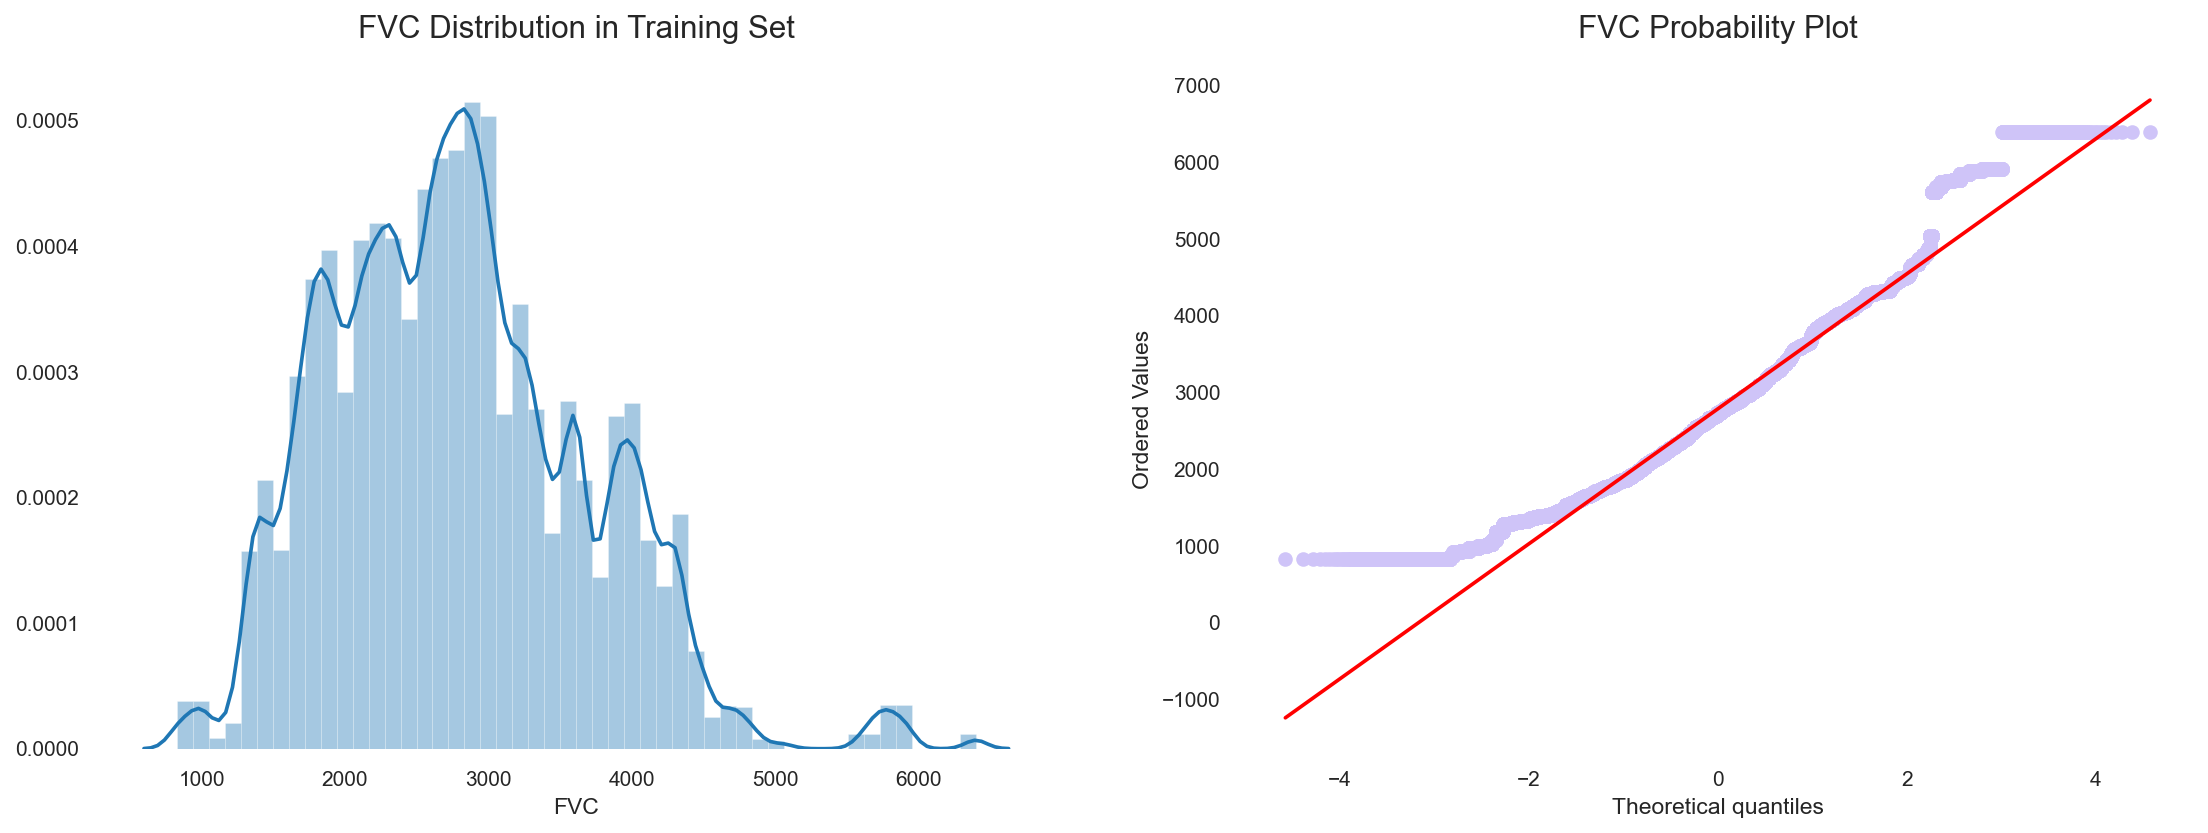

In [156]:
from scipy import stats

fig, axes = plt.subplots(ncols=2, figsize=(18, 6), dpi=150)
sns.distplot(df['FVC'], label='FVC', ax=axes[0])
stats.probplot(df['FVC'], plot=axes[1])
axes[0].set_title(f'FVC Distribution in Training Set', size=15, pad=15)
axes[1].set_title(f'FVC Probability Plot', size=15, pad=15)
axes[1].get_lines()[0].set_markerfacecolor('#cfc4f8')

<AxesSubplot:>

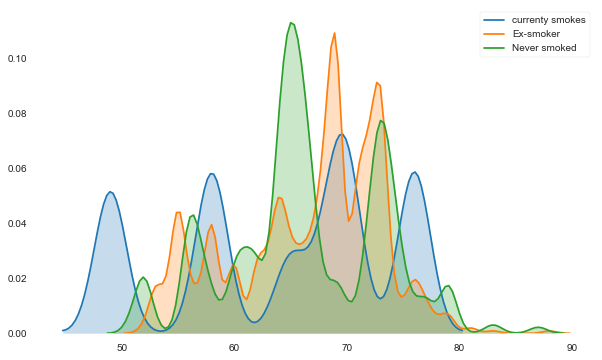

In [399]:
# smoking staus versus Age distribution
smoker_dist=df.loc[df.SmokingStatus=='Currently smokes']['Age']
exsmoker_dist=df.loc[df.SmokingStatus=='Ex-smoker']['Age']
nonsmoker_dist=df.loc[df.SmokingStatus=='Never smoked']['Age']

plt.figure(figsize=(10,6))
sns.kdeplot(smoker_dist,shade=True,label='currenty smokes')
sns.kdeplot(exsmoker_dist,shade=True,label='Ex-smoker')
sns.kdeplot(nonsmoker_dist,shade=True,label='Never smoked')

# train_patient_data = df

# plt.figure(figsize=(16, 6))
# sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
# sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
# sns.kdeplot(train_patient_data.loc[train_patient_data['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# # Labeling of plot
# plt.xlabel('Age (years)');
# plt.ylabel('Density');
# plt.title('Distribution of Ages over SmokingStatus');

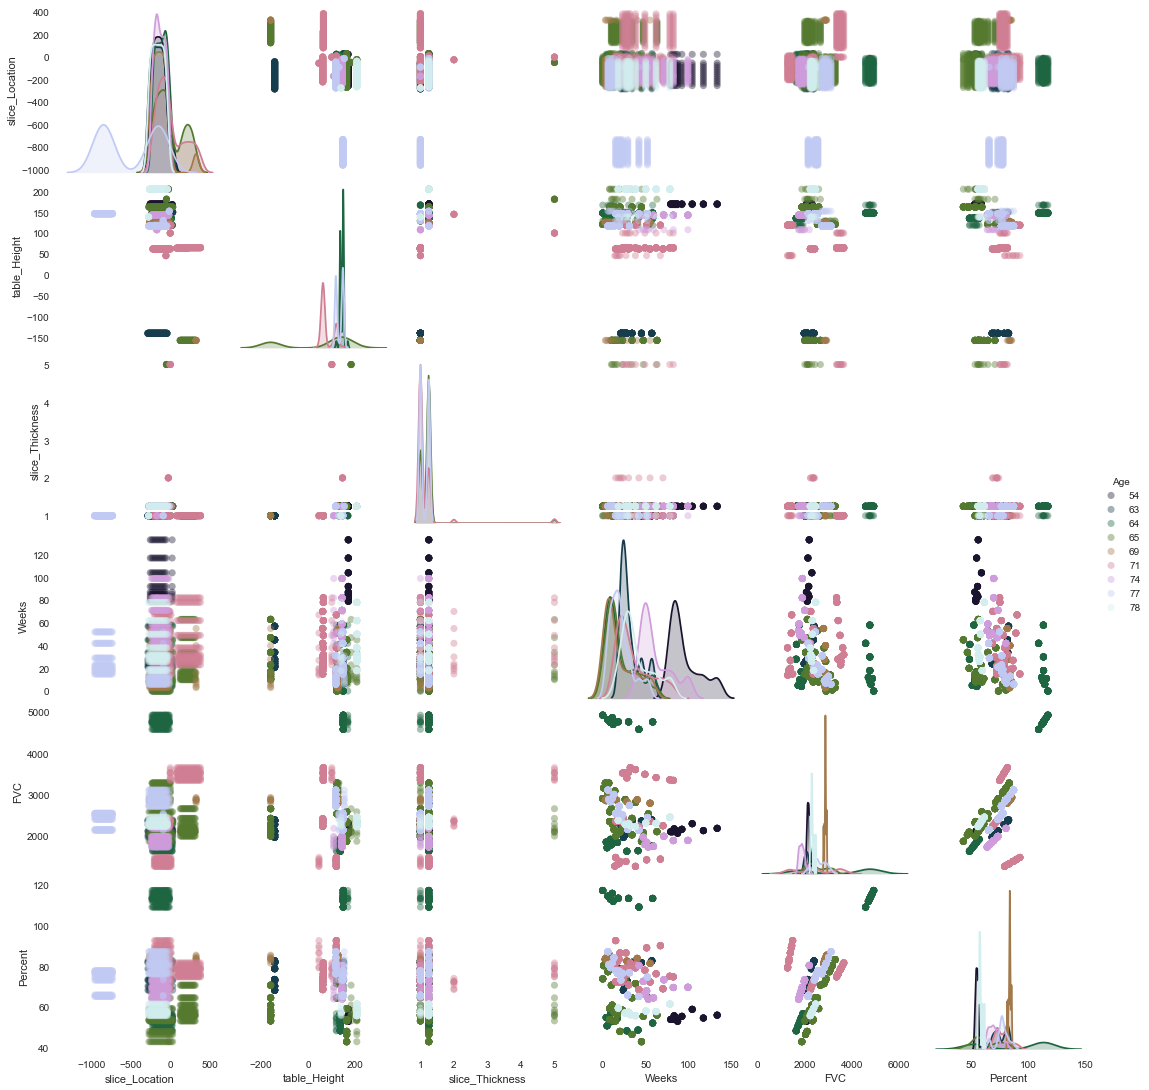

In [152]:
sample_ids = pd.DataFrame(df['patient_ID'].value_counts().tail(15)).reset_index()
sample_id_list = sample_ids['index'].tolist()
fifteen_patients_df = df[df['patient_ID'].isin(sample_id_list)]

g = sns.pairplot(fifteen_patients_df, hue="Age", palette="cubehelix",
                 diag_kind="kde",
                 plot_kws=dict(s=50, edgecolor="none", linewidth=1, alpha=0.4),
                 diag_kws=dict(shade=True))

<AxesSubplot:xlabel='FVC', ylabel='Weeks'>

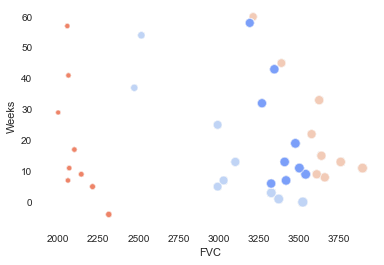

In [120]:
five_patients_df = df[(df['patient_ID'] == 'ID00007637202177411956430') | (df['patient_ID'] == 'ID00009637202177434476278') |(df['patient_ID'] == 'ID00010637202177584971671') |(df['patient_ID'] == 'ID00011637202177653955184')]

sns.scatterplot(x="FVC", y="Weeks", data=five_patients_df, hue="patient_ID",size="Percent", alpha=.4, legend=False, palette="coolwarm_r")

<AxesSubplot:xlabel='FVC', ylabel='Percent'>

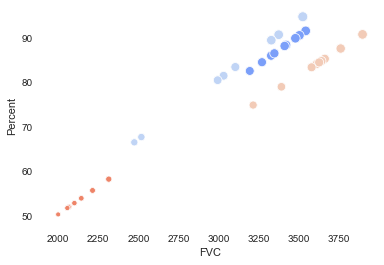

In [112]:
sns.scatterplot(x="FVC", y="Percent", data=five_patients_df, hue="patient_ID",size="Percent", legend=False, palette = "coolwarm_r")

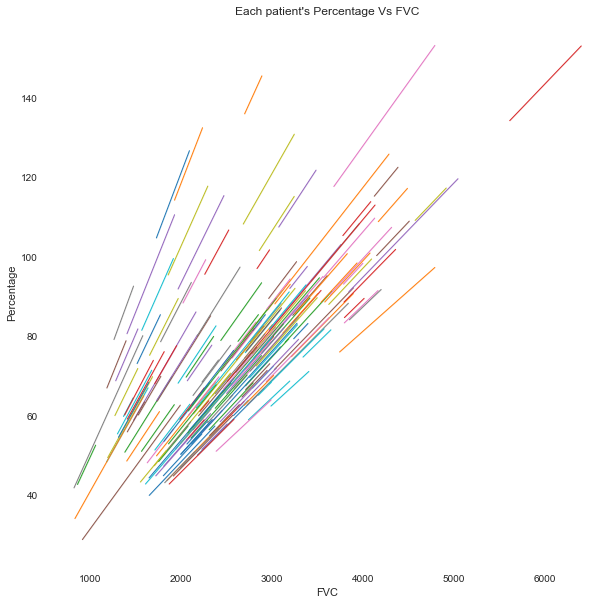

In [404]:
raw_data = df
patient_ids=df.patient_ID.unique()
patient_week=[]
patient_fvc=[]
patient_percentage=[]
for ids in patient_ids:
    week=raw_data.loc[raw_data['patient_ID']==ids]['Weeks'].values
    fvc=raw_data.loc[raw_data['patient_ID']==ids]['FVC'].values
    percent=raw_data.loc[raw_data['patient_ID']==ids]['Percent'].values
    patient_week.append(week)
    patient_fvc.append(fvc)
    patient_percentage.append(percent)

plt.figure(figsize=(10,10))
plt.title("Each patient's Percentage Vs FVC")
plt.xlabel('FVC')
plt.ylabel('Percentage')
for i in range(len(patient_ids)):
    sns.lineplot(x=patient_fvc[i],y=patient_percentage[i],label ='P'+str(i+1),lw=1,legend=False)

<AxesSubplot:xlabel='SmokingStatus', ylabel='count'>

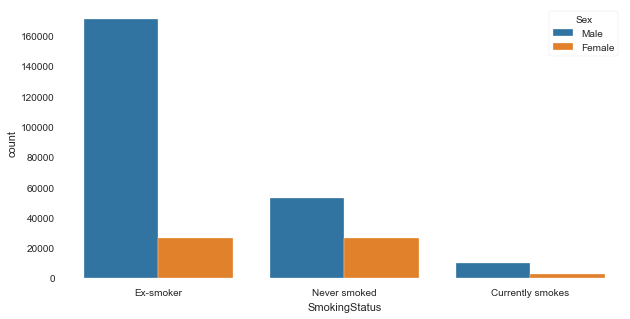

In [395]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='SmokingStatus', hue='Sex')

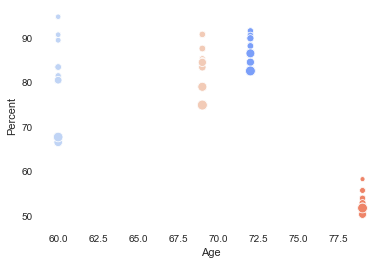

In [383]:
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=df, x='Age', hue='Percent')

ax = sns.scatterplot(x="Age", y="Percent", data=five_patients_df, hue = 'patient_ID', palette = "coolwarm_r", legend = False, size='Weeks')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Each patient's FVC decay over the weeks")
plt.xlabel('Weeks')
plt.ylabel('FVC deacy ')
for i in range(len(patient_ids)):
    sns.lineplot(x=patient_week[i],y=patient_fvc[i],label ='P'+str(i+1),lw=2,legend=False, alpha=.4)

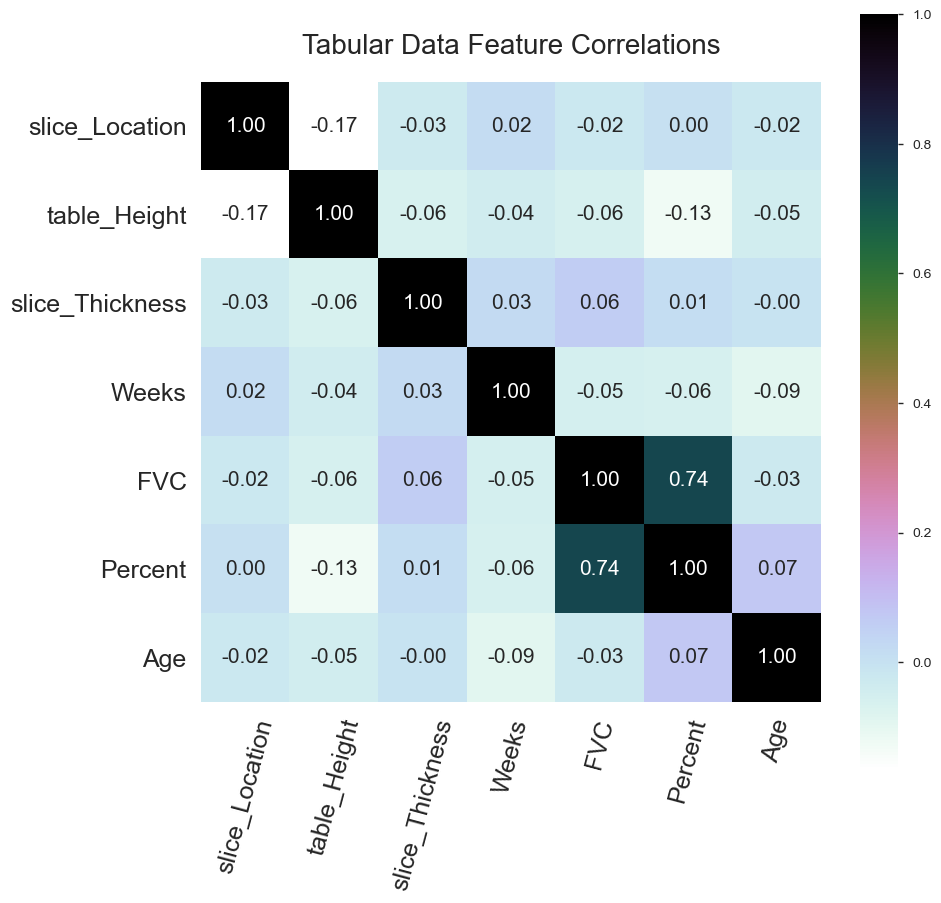

In [115]:
fig = plt.figure(figsize=(10, 10), dpi=100)

sns.heatmap(df.corr(), annot=True, square=True, annot_kws={'size': 15},  fmt='.2f', cmap="cubehelix_r")   

plt.tick_params(axis='x', labelsize=18, rotation=75)
plt.tick_params(axis='y', labelsize=18, rotation=0)
plt.title('Tabular Data Feature Correlations', size=20, pad=20)

plt.show()

In [41]:
from sklearn.preprocessing import OrdinalEncoder

np_encoded = OrdinalEncoder().fit_transform(df[['patient_ID', 'modality','patient_Position', 'Sex', 'SmokingStatus']])
df_encoded = pd.DataFrame({'patient_ID': np_encoded[:, 0], 'modality': np_encoded[:, 1], 'patient_Position': np_encoded[:, 2], 'Sex': np_encoded[:, 3], 'SmokingStatus': np_encoded[:, 4]})
df_encoded.nunique().sort_values(ascending = False)

patient_ID          176
patient_Position      5
SmokingStatus         3
Sex                   2
modality              2
dtype: int64

In [24]:
features = train.drop(columns=[target, 'patient_ID'])
features.head(1)

sop_Instance_UID modality  slice_Location  \
0        2.25.12297650151329871895440507938349160734       CT          -69.75   
1        2.25.12297650151329871895440507938349160734       CT          -69.75   
2        2.25.12297650151329871895440507938349160734       CT          -69.75   
3        2.25.12297650151329871895440507938349160734       CT          -69.75   
4        2.25.12297650151329871895440507938349160734       CT          -69.75   
...                                              ...      ...             ...   
289830  2.25.168905127791367184474415800608234029037      nan            0.00   
289831  2.25.168905127791367184474415800608234029037      nan            0.00   
289832  2.25.168905127791367184474415800608234029037      nan            0.00   
289833  2.25.168905127791367184474415800608234029037      nan            0.00   
289834  2.25.168905127791367184474415800608234029037      nan            0.00   

        table_Height         image_Position_Patient  \
0              130.0  [-158.700, -153.500, -69.750]   
1              130.0  [-158.700, -153.500, -69.750]   
2              130.0  [-158.700, -153.500, -69.750]   
3              130.0  [-158.700, -153.500, -69.750]   
4              130.0  [-158.700, -153.500, -69.750]   
...              ...                            ...   
289830           0.0                              0   
289831           0.0                              0   
289832           0.0                              0   
289833           0.0                              0   
289834           0.0                              0   

                                image_Orientation_Patient patient_Position  \
0       [1.000000, 0.000000, 0.000000, 0.000000, 1.000...              FFS   
1       [1.000000, 0.000000, 0.000000, 0.000000, 1.000...              FFS   
2       [1.000000, 0.000000, 0.000000, 0.000000, 1.000...              FFS   
3       [1.000000, 0.000000, 0.000000, 0.000000, 1.000...              FFS   
4       [1.000000, 0.000000, 0.000000, 0.000000, 1.000...              FFS   
...                                                   ...              ...   
289830                                                  0              nan   
289831                                                  0              nan   
289832                                                  0              nan   
289833                                                  0              nan   
289834                                                  0              nan   

        slice_Thickness         pixel_Spacing  Weeks    Percent  Age   Sex  \
0                  1.25  [0.652344, 0.652344]     -4  58.253649   79  Male   
1                  1.25  [0.652344, 0.652344]      5  55.712129   79  Male   
2                  1.25  [0.652344, 0.652344]      7  51.862104   79  Male   
3                  1.25  [0.652344, 0.652344]      9  53.950679   79  Male   
4                  1.25  [0.652344, 0.652344]     11  52.063412   79  Male   
...                 ...                   ...    ...        ...  ...   ...   
289830             0.00                     0     13  66.594637   73  Male   
289831             0.00                     0     19  73.126412   73  Male   
289832             0.00                     0     31  71.407524   73  Male   
289833             0.00                     0     43  73.052745   73  Male   
289834             0.00                     0     59  68.117081   73  Male   

       SmokingStatus  
0          Ex-smoker  
1          Ex-smoker  
2          Ex-smoker  
3          Ex-smoker  
4          Ex-smoker  
...              ...  
289830  Never smoked  
289831  Never smoked  
289832  Never smoked  
289833  Never smoked  
289834  Never smoked  

[195279 rows x 14 columns]

In [60]:
from sklearn.model_selection import GroupShuffleSplit

train_inds, val_inds = next(GroupShuffleSplit(test_size=.35, n_splits=2, random_state = 42).split(df, groups=df['patient_ID']))
train = df.iloc[train_inds]
val = df.iloc[val_inds]

col = 'patient_ID'

cardinality = len(pd.Index(df[col]).value_counts())
print(df[col].name + " in df: " + str(cardinality))
print(' ')    
cardinality = len(pd.Index(train[col]).value_counts())
print(train[col].name + " in train: " + str(cardinality))
print(' ')    
cardinality = len(pd.Index(val[col]).value_counts())
print(val[col].name + " in val: " + str(cardinality))

target = 'FVC'
features = train.drop(columns=[target, 'patient_ID']).columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

patient_ID in df: 176
 
patient_ID in train: 114
 
patient_ID in val: 62


Training r2score: 0.8796990028666275
Val r2score 0.8683244540341744


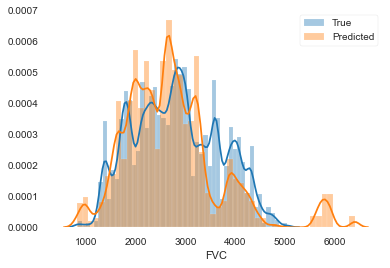

In [62]:
from sklearn.preprocessing import StandardScaler

model2 = make_pipeline(ce.OrdinalEncoder(),
                       StandardScaler(),
                       LinearRegression())
model2.fit(X_train,y_train)
y_train_pred = model2.predict(X_train)
y_val_pred = model2.predict(X_val)

print("Training r2score:",r2_score(y_train,y_train_pred))
print("Val r2score",r2_score(y_val,y_val_pred))

sns.distplot(y_train, label='True')
sns.distplot(y_val, label='Predicted')
plt.legend();

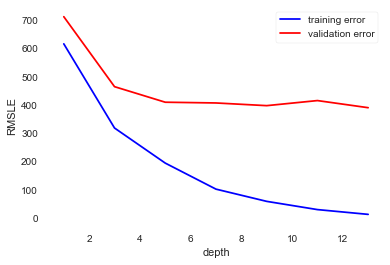

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor())

depth = range(1, 15, 2)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_squared_error', 
    cv=2, groups=groups)

train_rmsle = np.sqrt(-train_scores)
val_rmsle = np.sqrt(-val_scores)
plt.plot(depth, np.mean(train_rmsle, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_rmsle, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('RMSLE')
plt.legend();

Validation Accuracy 0.6953522298033104


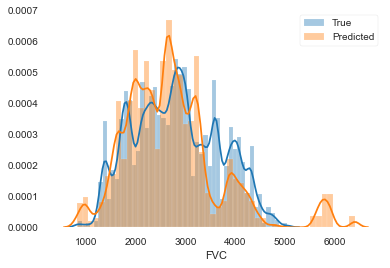

In [65]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    DecisionTreeRegressor(max_depth = 5, random_state=42 ,min_samples_leaf=5)


)
#Fit on Train
pipeline.fit(X_train, y_train)
#Score on Val
print('Validation Accuracy', pipeline.score(X_val, y_val))

sns.distplot(y_train, label='True')
sns.distplot(y_val, label='Predicted')
plt.legend();

In [31]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_features': uniform(),
    'randomforestregressor__min_samples_leaf': [1, 10, 100]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train, groups=groups)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   52.0s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.0min remaining:   52.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CA204ECD08>,
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    10,
                                                                                    100],
                                        'randomforestregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CA09D78E88>},
                   return_train_score=True, scoring='neg_mean_squared_

In [32]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.6141449480621729, 'randomforestregressor__min_samples_leaf': 10, 'randomforestregressor__n_estimators': 470}
Cross-validation RMSLE 359.6282298461776


In [33]:
results_df = pd.DataFrame(search.cv_results_)
results_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      47.509307      0.333499         1.784499        0.062502   
1     112.789307      3.319500         3.219499        0.237502   
2      18.772305      0.028501         1.139001        0.100999   
3     125.936308      4.438498         1.687001        0.148002   
4      92.144501      3.231500         1.747500        0.255499   

  param_randomforestregressor__max_features  \
0                                  0.419274   
1                                  0.614145   
2                                  0.336222   
3                                  0.972045   
4                                  0.909947   

  param_randomforestregressor__min_samples_leaf  \
0                                           100   
1                                            10   
2                                            10   
3                                             1   
4                                           100   

  param_randomforestregressor__n_estimators  \
0                                       266   
1                                       470   
2                                       103   
3                                       345   
4                                       293   

                                              params  split0_test_score  \
0  {'randomforestregressor__max_features': 0.4192...     -130607.487133   
1  {'randomforestregressor__max_features': 0.6141...      -93301.558252   
2  {'randomforestregressor__max_features': 0.3362...     -180645.532052   
3  {'randomforestregressor__max_features': 0.9720...     -141594.360002   
4  {'randomforestregressor__max_features': 0.9099...     -125389.397871   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
0     -248074.632765   -189341.059949    58733.572816                4   
1     -165363.369153   -129332.463702    36030.905451                1   
2     -263767.593474   -222206.562763    41561.030711                5   
3     -140044.767403   -140819.563703      774.796299                3   
4     -150311.867996   -137850.632934    12461.235063                2   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
0        -1592.538437         -777.303062      -1184.920749       407.617688  
1         -140.845615          -78.126137       -109.485876        31.359739  
2         -361.247725         -264.160619       -312.704172        48.543553  
3          -10.856424           -6.826716         -8.841570         2.014854  
4        -1277.334388         -398.128585       -837.731487       439.602902

In [34]:
results_df.sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1     112.789307      3.319500         3.219499        0.237502   
4      92.144501      3.231500         1.747500        0.255499   
3     125.936308      4.438498         1.687001        0.148002   
0      47.509307      0.333499         1.784499        0.062502   
2      18.772305      0.028501         1.139001        0.100999   

  param_randomforestregressor__max_features  \
1                                  0.614145   
4                                  0.909947   
3                                  0.972045   
0                                  0.419274   
2                                  0.336222   

  param_randomforestregressor__min_samples_leaf  \
1                                            10   
4                                           100   
3                                             1   
0                                           100   
2                                            10   

  param_randomforestregressor__n_estimators  \
1                                       470   
4                                       293   
3                                       345   
0                                       266   
2                                       103   

                                              params  split0_test_score  \
1  {'randomforestregressor__max_features': 0.6141...      -93301.558252   
4  {'randomforestregressor__max_features': 0.9099...     -125389.397871   
3  {'randomforestregressor__max_features': 0.9720...     -141594.360002   
0  {'randomforestregressor__max_features': 0.4192...     -130607.487133   
2  {'randomforestregressor__max_features': 0.3362...     -180645.532052   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  \
1     -165363.369153   -129332.463702    36030.905451                1   
4     -150311.867996   -137850.632934    12461.235063                2   
3     -140044.767403   -140819.563703      774.796299                3   
0     -248074.632765   -189341.059949    58733.572816                4   
2     -263767.593474   -222206.562763    41561.030711                5   

   split0_train_score  split1_train_score  mean_train_score  std_train_score  
1         -140.845615          -78.126137       -109.485876        31.359739  
4        -1277.334388         -398.128585       -837.731487       439.602902  
3          -10.856424           -6.826716         -8.841570         2.014854  
0        -1592.538437         -777.303062      -1184.920749       407.617688  
2         -361.247725         -264.160619       -312.704172        48.543553

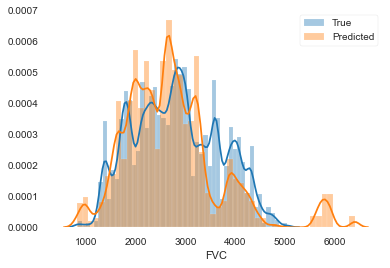

In [35]:
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_val)

sns.distplot(y_train, label='True')
sns.distplot(y_val, label='Predicted')
plt.legend();

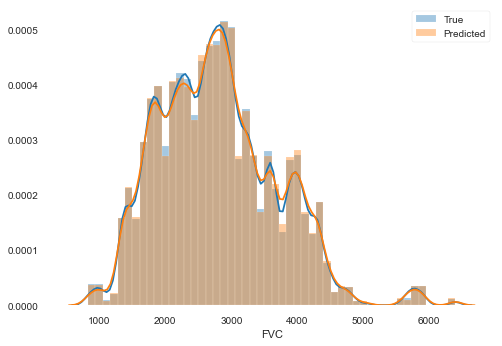

In [103]:
sns.distplot(y_train, label='True')
sns.distplot(y_val, label='Predicted')
plt.legend();

<AxesSubplot:>

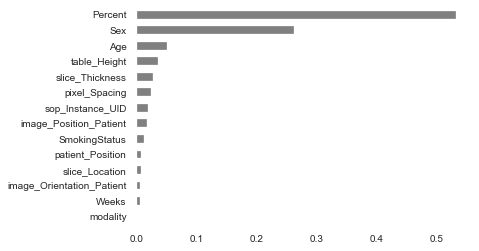

In [36]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey')

In [108]:
# Just Use Categorical features
features = ['modality',
             'patient_Position',
             'Sex',
             'SmokingStatus']

# Arrange data into X features matrix and y target vector 
X_train_cat = train[features]
y_train_cat = train[target]
X_val_cat = val[features]
y_val_cat = val[target]
X_train_cat.head(1)

modality patient_Position   Sex SmokingStatus
260701       CT              HFS  Male     Ex-smoker

In [86]:
X_val_cat.head(1)

modality patient_Position   Sex SmokingStatus
28167       CT              HFS  Male     Ex-smoker

In [118]:
print('Validation Accuracy', pipeline.score(X_val_cat,y_val_cat))

Validation Accuracy 0.02607215558187945


In [ ]:
# Example predicting Confidence

from statsmodels.formula.api import quantreg

modelL = quantreg('FVC ~ Weeks+Percent+Age+Sex+SmokingStatus', train).fit( q=0.15 )
model  = quantreg('FVC ~ Weeks+Percent+Age+Sex+SmokingStatus', train).fit( q=0.50 )
modelH = quantreg('FVC ~ Weeks+Percent+Age+Sex+SmokingStatus', train).fit( q=0.85 )
print(model.summary())

train['ypredL'] = modelL.predict( train ).values
train['ypred']  = model.predict( train ).values
train['ypredH'] = modelH.predict( train ).values
train['ypredstd'] = 0.5*np.abs(train['ypredH'] - train['ypred'])+0.5*np.abs(train['ypred'] - train['ypredL'])
train.head(10)

def metric( trueFVC, predFVC, predSTD ):
    
    clipSTD = np.clip( predSTD, 70 , 9e9 )  
    
    deltaFVC = np.clip( np.abs(trueFVC-predFVC), 0 , 1000 )  

    return np.mean( -1*(np.sqrt(2)*deltaFVC/clipSTD) - np.log( np.sqrt(2)*clipSTD ) )
    

print( 'Metric:', metric( train['FVC'].values, train['ypred'].values, train['ypredstd'].values  ) )

dt = train.loc[ train.traintest==1 ,['Patient','Percent','Age','Sex','SmokingStatus']]
test = pd.merge( sub, dt, on='Patient', how='left' )
test.sort_values( ['Patient','Weeks'], inplace=True )
test.head(10)

test['ypredL'] = modelL.predict( test ).values
test['FVC']    = model.predict( test ).values
test['ypredH'] = modelH.predict( test ).values
test['Confidence'] = np.abs(test['ypredH'] - test['ypredL']) / 2

test.head(10)

test[['Patient_Week','FVC','Confidence']].to_csv('submission.csv', index=False)
test[['Patient_Week','FVC','Confidence']].head(10)

In [ ]:
# Ridge regression outputting Confidence in 'oop'

def run_single_ridge(param, train_df, test_df, folds, features, target, fold_num=0):
    
    trn_idx = folds[folds.fold!=fold_num].index
    val_idx = folds[folds.fold==fold_num].index
    
    y_tr = target.iloc[trn_idx].values
    X_tr = train_df.iloc[trn_idx][features].values
    y_val = target.iloc[val_idx].values
    X_val = train_df.iloc[val_idx][features].values
    
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    
    clf = Ridge(**param)
    clf.fit(X_tr, y_tr)
    
    oof[val_idx] = clf.predict(X_val)
    predictions += clf.predict(test_df[features])

    logger.info("fold{} score: {:<8.5f}"
                .format(fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions


def run_kfold_ridge(param, train, test, folds, features, target, n_fold=5):
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        
        logger.info("Fold {}".format(fold_))
        _oof, _predictions = run_single_ridge(param, 
                                                    train, 
                                                    test,
                                                    folds,  
                                                    features,
                                                    target, 
                                                    fold_num=fold_)
        oof += _oof
        predictions += _predictions/n_fold
    
    logger.info("CV score: {:<8.5f}"
                .format(np.sqrt(mean_squared_error(target, oof))))
    
    return oof, predictions